In [1]:
import os
import cv2
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Plotting Result
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\govinda\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define a custom dataset class
class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.frames = []
        self.labels = []

        # Load data paths and labels
        for label, category in enumerate(['original', 'altered']):
            category_dir = os.path.join(root_dir, category)
            for video_file in os.listdir(category_dir):
                video_path = os.path.join(category_dir, video_file)
                self.frames.append(video_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        # Load video frame
        video_path = self.frames[idx]
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()

        if not ret:
            raise ValueError(f"Unable to read frame from {video_path}")

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Apply transformations
        if self.transform:
            frame = self.transform(frame)

        label = self.labels[idx]
        return frame, label

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [4]:
# Initialize ViT feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

C:\Users\govinda\AppData\Roaming\Python\Python312\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
# Custom function to preprocess and batch images
def preprocess_and_batch(frames):
    # Convert frames to PIL images and apply transformations
    frames = [transform(frame) for frame in frames]
    # Batch frames
    batch = torch.stack(frames)
    return batch

In [6]:
# Define dataset paths

# datadir = '/content/drive/MyDrive/Deepfake/'
datadir = './dataset/'

# train_dir = datadir + "trainnew"
# val_dir = datadir + "valnew"
# test_dir = datadir + "testnew"
train_dir = datadir + "train"
val_dir = datadir + "val"
test_dir = datadir + "test"

In [7]:
# Create datasets
train_dataset = VideoFrameDataset(root_dir=train_dir, transform=transform)
val_dataset = VideoFrameDataset(root_dir=val_dir, transform=transform)
test_dataset = VideoFrameDataset(root_dir=test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize ViT feature extractor and model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,  # Specify the number of classes here
    ignore_mismatched_sizes=True  # This will ignore the size mismatch
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
# Variables to store metrics for plotting
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []

# Training loop
num_epochs = 10
best_val_accuracy = 0  # Variable to track the best validation accuracy

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0
    running_loss = 0.0
    for batch_idx, (frames, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Convert frames to PIL images
        frames = [transforms.ToPILImage()(frame) for frame in frames]

        # Process frames through feature extractor
        inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
        outputs = model(inputs).logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy}%')

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for frames, labels in val_loader:
            # Convert frames to PIL images
            frames = [transforms.ToPILImage()(frame) for frame in frames]

            # Process frames through feature extractor
            inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
            outputs = model(inputs).logits

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy}%')

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f"best_model_epoch_{epoch+1}.pth")
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {val_accuracy}%")

    # Test phase
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for frames, labels in test_loader:
            # Convert frames to PIL images
            frames = [transforms.ToPILImage()(frame) for frame in frames]

            # Process frames through feature extractor
            inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
            outputs = model(inputs).logits

            # Calculate test accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy}%')

Epoch [1/10], Train Accuracy: 49.21875%
Epoch [1/10], Validation Accuracy: 50.66225165562914%
Best model saved at epoch 1 with validation accuracy: 50.66225165562914%
Epoch [1/10], Test Accuracy: 50.16611295681063%
Epoch [2/10], Train Accuracy: 46.37784090909091%
Epoch [2/10], Validation Accuracy: 50.33112582781457%
Epoch [2/10], Test Accuracy: 50.16611295681063%
Epoch [3/10], Train Accuracy: 50.92329545454545%
Epoch [3/10], Validation Accuracy: 63.57615894039735%
Best model saved at epoch 3 with validation accuracy: 63.57615894039735%
Epoch [3/10], Test Accuracy: 62.12624584717608%
Epoch [4/10], Train Accuracy: 58.16761363636363%
Epoch [4/10], Validation Accuracy: 60.59602649006622%
Epoch [4/10], Test Accuracy: 59.136212624584715%
Epoch [5/10], Train Accuracy: 63.49431818181818%
Epoch [5/10], Validation Accuracy: 66.55629139072848%
Best model saved at epoch 5 with validation accuracy: 66.55629139072848%
Epoch [5/10], Test Accuracy: 61.794019933554814%
Epoch [6/10], Train Accuracy: 70.

In [10]:
# Plot graphs for accuracy and loss
epochs = range(1, num_epochs + 1)

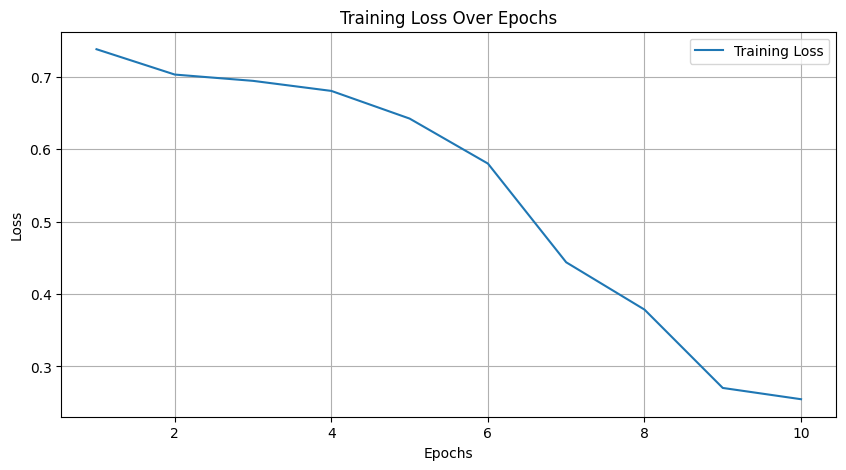

In [11]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

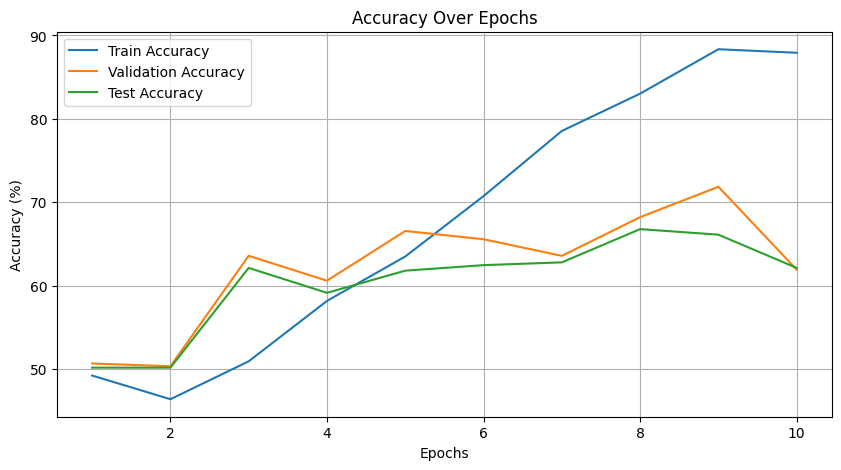

In [12]:
# Plot accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Create a DataFrame for the table
results_table = pd.DataFrame({
    'Epoch': epochs,
    'Training Accuracy (%)': train_accuracies,
    'Validation Accuracy (%)': val_accuracies,
    'Test Accuracy (%)': test_accuracies,
    'Training Loss': train_losses
})

In [14]:
# Display the results table
print("\nResults Table:")
print(results_table)


Results Table:
   Epoch  Training Accuracy (%)  Validation Accuracy (%)  Test Accuracy (%)  \
0      1              49.218750                50.662252          50.166113   
1      2              46.377841                50.331126          50.166113   
2      3              50.923295                63.576159          62.126246   
3      4              58.167614                60.596026          59.136213   
4      5              63.494318                66.556291          61.794020   
5      6              70.738636                65.562914          62.458472   
6      7              78.551136                63.576159          62.790698   
7      8              83.025568                68.211921          66.777409   
8      9              88.352273                71.854305          66.112957   
9     10              87.926136                61.920530          62.126246   

   Training Loss  
0       0.738132  
1       0.703138  
2       0.694440  
3       0.680557  
4       0.642341  


In [15]:
import torch

# Training loop
num_epochs = 10
best_val_accuracy = 0  # Variable to track the best validation accuracy

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_correct = 0
    train_total = 0
    for batch_idx, (frames, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Convert frames to PIL images
        frames = [transforms.ToPILImage()(frame) for frame in frames]

        # Process frames through feature extractor
        inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
        outputs = model(inputs).logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy}%')

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for frames, labels in val_loader:
            # Convert frames to PIL images
            frames = [transforms.ToPILImage()(frame) for frame in frames]

            # Process frames through feature extractor
            inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
            outputs = model(inputs).logits

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy}%')

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f"best_fit_model_epoch_{epoch+1}.pth")
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {val_accuracy}%")

    # Test phase
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for frames, labels in test_loader:
            # Convert frames to PIL images
            frames = [transforms.ToPILImage()(frame) for frame in frames]

            # Process frames through feature extractor
            inputs = feature_extractor(images=frames, return_tensors="pt").pixel_values.squeeze(1)
            outputs = model(inputs).logits

            # Calculate test accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy}%')


Epoch [1/10], Train Accuracy: 92.32954545454545%
Epoch [1/10], Validation Accuracy: 68.21192052980132%
Best model saved at epoch 1 with validation accuracy: 68.21192052980132%
Epoch [1/10], Test Accuracy: 64.78405315614619%
Epoch [2/10], Train Accuracy: 93.39488636363636%
Epoch [2/10], Validation Accuracy: 65.89403973509934%
Epoch [2/10], Test Accuracy: 65.78073089700996%
Epoch [3/10], Train Accuracy: 95.5965909090909%
Epoch [3/10], Validation Accuracy: 64.90066225165563%
Epoch [3/10], Test Accuracy: 62.7906976744186%
Epoch [4/10], Train Accuracy: 95.8096590909091%
Epoch [4/10], Validation Accuracy: 69.86754966887418%
Best model saved at epoch 4 with validation accuracy: 69.86754966887418%
Epoch [4/10], Test Accuracy: 67.77408637873754%
Epoch [5/10], Train Accuracy: 96.23579545454545%
Epoch [5/10], Validation Accuracy: 69.5364238410596%
Epoch [5/10], Test Accuracy: 68.43853820598007%
Epoch [6/10], Train Accuracy: 96.16477272727273%
Epoch [6/10], Validation Accuracy: 67.54966887417218%


In [14]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

No GPU available. Training will run on CPU.
